In [ ]:
!pip install python-graphblas[default]
!pip install ssgetpy

In [2]:
import numpy as np
import graphblas as gb
gb.init("suitesparse", blocking=False)
import numpy as np
from graphblas import Matrix, dtypes, unary, binary, monoid, semiring, Recorder, Vector
from graphblas.io import mmread

import glob
import os
from scipy.sparse import coo_matrix
import timeit
import matplotlib.pyplot as plt

import ssgetpy
from tqdm import tqdm
import shutil

# 0. Вспомогательные функции

### Преобразование квадратной матрицы смежности в sparse matrix и обратно, генерация рандомных графов для тестирования


In [3]:
def dense2sparse(A):
    rows, cols, vals = A.to_coo()
    mask = vals.nonzero()
    A_sparse = gb.Matrix.from_coo(rows[mask], cols[mask], vals[mask], nrows = A.shape[0], ncols = A.shape[1])
    return A_sparse


def sparse2dense(A_sparse):
    rows, cols, vals = A_sparse.to_coo()
    A = coo_matrix((vals, (rows, cols))).toarray()
    A = gb.Matrix.from_dense(A)
    return A

def random_graph(n, p):
    A_np = np.random.choice(a=[0, 1], size=(n, n), p=[1 - p, p])
    return dense2sparse(gb.Matrix.from_dense(A_np))

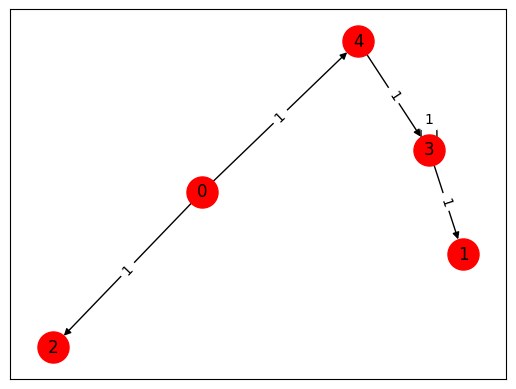

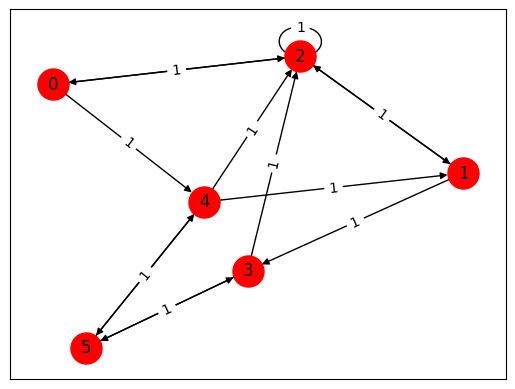

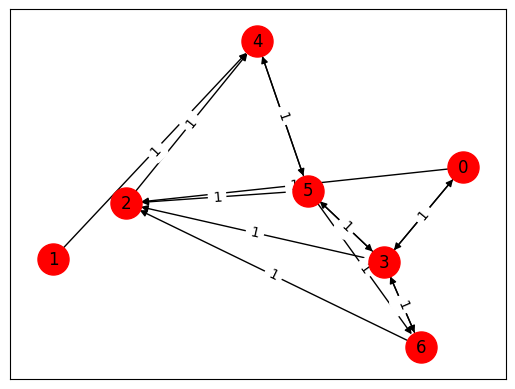

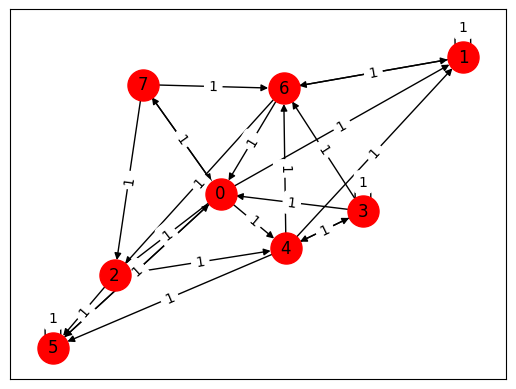

In [4]:
test_graphs_params = [(5, 0.2), (6, 0.3), (7, 0.3), (8, 0.4)]
test_graphs = [random_graph(*pair) for pair in test_graphs_params]
for graph in test_graphs:
    gb.viz.draw(graph)

## 1.Используя python-graphblas реализовать функцию обхода ориентированного графа (MSBFS-Levels) в ширину из нескольких заданных стартовых вершин.

In [5]:
def MSBFS_Levels(A, start_vertexs):
    n_vertexs, n_start_vertexs = A.nrows, len(start_vertexs)
    res = Matrix(dtypes.INT32, n_start_vertexs, n_vertexs)
    f = Matrix(bool, n_start_vertexs, n_vertexs)
    succ = Vector(bool, n_start_vertexs)
    for idx, vertex in enumerate(start_vertexs):
        f[idx,vertex] << True
    level=0
    while True:
        res(mask=f.V) << level
        f(~res.S, replace=True) << f.mxm(A, semiring.lor_land)
        for idx in range(n_start_vertexs):
            succ[idx] << f[idx,:].reduce(monoid.lor, allow_empty=False)
        if not succ.dup(dtype=dtypes.UINT64).reduce(gb.agg.sum).value:
            break
        level+=1
    res_list = []
    for idx in range(n_start_vertexs):
        buff=[]
        for vert_idx in range(n_vertexs):
            if res[idx,vert_idx].value is None:
                buff.append(-1)
            else:
                buff.append(res[idx,vert_idx].value)
        res_list.append(np.array(buff))
    return list(zip(start_vertexs, res_list))

Vertex: 3, levels: [-1  1 -1  0 -1]
Vertex: 1, levels: [-1  0 -1 -1 -1]


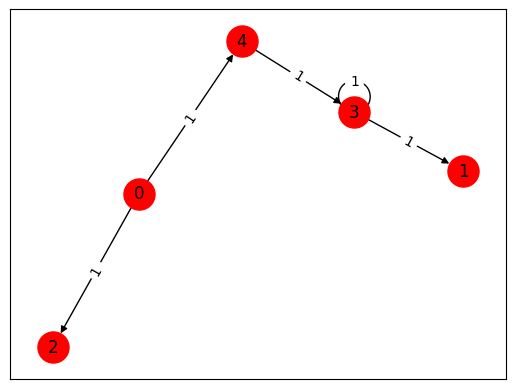

Vertex: 2, levels: [1 1 0 2 2 3]
Vertex: 3, levels: [2 2 1 0 2 1]
Vertex: 4, levels: [2 1 1 2 0 1]


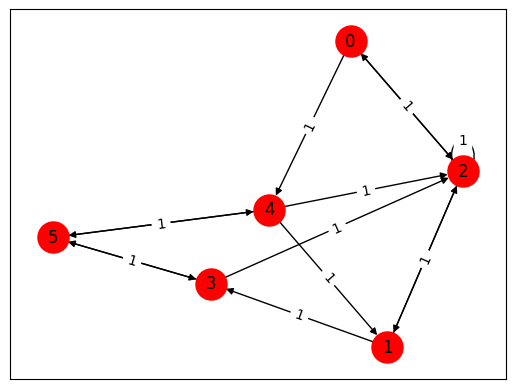

Vertex: 4, levels: [ 3 -1  2  2  0  1  2]


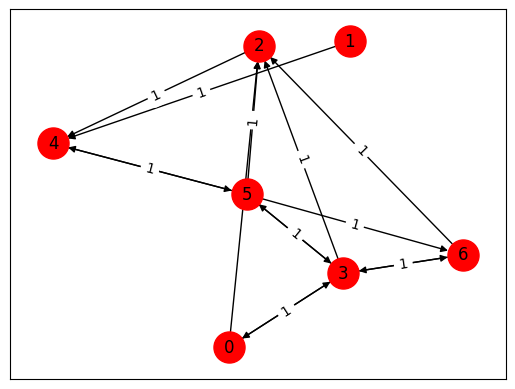

Vertex: 4, levels: [2 1 2 1 0 1 1 3]
Vertex: 2, levels: [2 2 0 2 1 1 2 3]
Vertex: 5, levels: [1 2 2 3 2 0 3 2]
Vertex: 7, levels: [1 2 1 3 2 2 1 0]


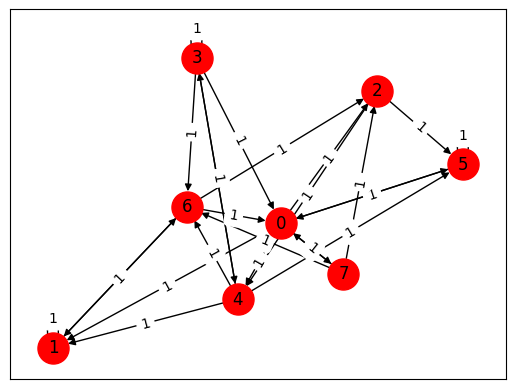

In [6]:
for graph, graph_params in zip(test_graphs, test_graphs_params):
    possible_vertexs = list(range(1, graph_params[0]))
    n_start_vertexs = np.random.randint(1, graph_params[0])
    start_vertexs = np.random.choice(possible_vertexs, n_start_vertexs, replace = False)
    res_list = MSBFS_Levels(graph, start_vertexs)
    for vertx, levels in res_list:
        print(f"Vertex: {vertx}, levels: {levels}")
    gb.viz.draw(graph)

## 2.Используя python-graphblas реализовать функцию обхода ориентированного графа (MSBFS-Parents) в ширину из нескольких заданных стартовых вершин.

In [7]:
def MSBFS_Parents(A, start_vertexs):
    n_vertexs, n_start_vertexs = A.nrows, len(start_vertexs)
    index_ramp = Matrix(dtypes.UINT64, n_start_vertexs, n_vertexs)
    parents = Matrix(dtypes.UINT64, n_start_vertexs, n_vertexs)
    curr_levels = Matrix(dtypes.UINT64, n_start_vertexs, n_vertexs)
    for idx, vertex in enumerate(start_vertexs):
        for vert_idx in range(n_vertexs):
            index_ramp[idx,vertex] << vertex
    for idx, vertex in enumerate(start_vertexs):
        parents[idx,vertex] << vertex
        curr_levels[idx, vertex] << 1
    while curr_levels.nvals > 0:
        curr_levels << index_ramp.ewise_mult(curr_levels, binary.first)
        curr_levels(~parents.S, replace=True) << curr_levels.mxm(A, semiring.min_first)
        parents(binary.plus) << curr_levels
    res_list = []
    for idx, vertex in enumerate(start_vertexs):
        buff=[]
        for vert_idx in range(n_vertexs):
            if parents[idx,vert_idx].value is None:
                buff.append(-2)
            elif vert_idx==vertex:
                buff.append(-1)
            else:
                buff.append(parents[idx,vert_idx].value)
        res_list.append(np.array(buff))
    return list(zip(start_vertexs, res_list))

Vertex: 1, levels: [-2 -1 -2 -2 -2]
Vertex: 3, levels: [-2  3 -2 -1 -2]


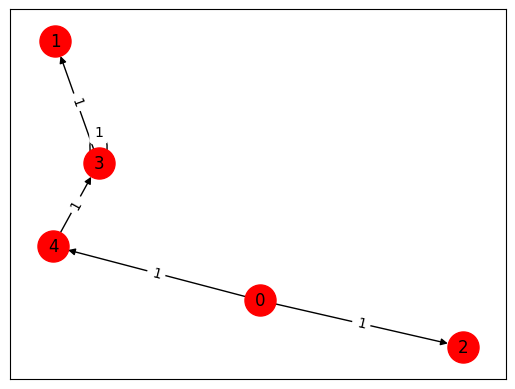

Vertex: 1, levels: [-2 -1  1  1 -2 -2]
Vertex: 3, levels: [-2 -2  3 -1 -2  3]
Vertex: 2, levels: [ 2  2 -1 -2 -2 -2]
Vertex: 5, levels: [-2 -2 -2  5  5 -1]
Vertex: 4, levels: [-2  4  4 -2 -1  4]


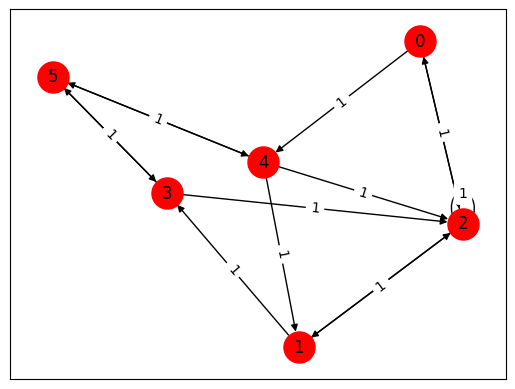

Vertex: 3, levels: [ 3 -2  3 -1 -2  3  3]
Vertex: 4, levels: [-2 -2 -2 -2 -1  4 -2]
Vertex: 1, levels: [-2 -1 -2 -2  1 -2 -2]
Vertex: 2, levels: [-2 -2 -1 -2  2 -2 -2]
Vertex: 5, levels: [-2 -2  5  5  5 -1  5]
Vertex: 6, levels: [-2 -2  6  6 -2 -2 -1]


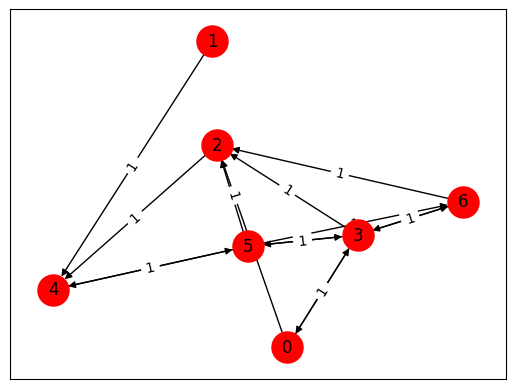

Vertex: 4, levels: [-2  4 -2  4 -1  4  4 -2]
Vertex: 2, levels: [-2 -2 -1 -2  2  2 -2 -2]
Vertex: 1, levels: [-2 -1 -2 -2 -2 -2  1 -2]
Vertex: 5, levels: [ 5 -2 -2 -2 -2 -1 -2 -2]


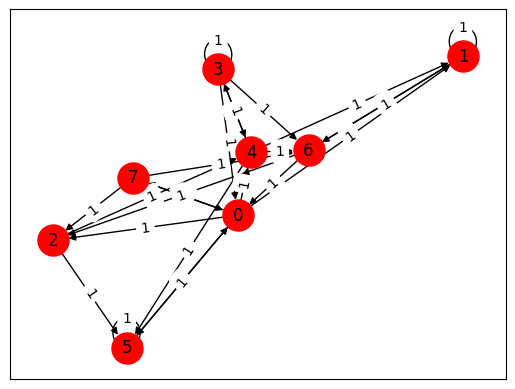

In [8]:
for graph, graph_params in zip(test_graphs, test_graphs_params):
    possible_vertexs = list(range(1, graph_params[0]))
    n_start_vertexs = np.random.randint(1, graph_params[0])
    start_vertexs = np.random.choice(possible_vertexs, n_start_vertexs, replace = False)
    res_list = MSBFS_Parents(graph, start_vertexs)
    for vertx, levels in res_list:
        print(f"Vertex: {vertx}, levels: {levels}")
    gb.viz.draw(graph)

Проверяем глазами все графы и результаты работы алгоритмов на них, и видим, что алгоритмы работают как и ожидалось

## 4. Добавить реализации описанных алгоритмов с использованием других полуколец (any.pair для levels и any.first для parents). Добавить тесты для проверки корректности. Провести экспериментальное исследование со сравнением этих реализаций с первоначальными на различных графах. (Исследование будет ниже)

In [9]:
def MSBFS_Levels_any_pair(A, start_vertexs):
    n_vertexs, n_start_vertexs = A.nrows, len(start_vertexs)
    res = Matrix(dtypes.INT32, n_start_vertexs, n_vertexs)
    f = Matrix(bool, n_start_vertexs, n_vertexs)
    succ = Vector(bool, n_start_vertexs)
    for idx, vertex in enumerate(start_vertexs):
        f[idx,vertex] << True
    level=0
    while True:
        res(mask=f.V) << level
        f(~res.S, replace=True) << f.mxm(A, semiring.any_pair)
        for idx in range(n_start_vertexs):
            succ[idx] << f[idx,:].reduce(monoid.lor, allow_empty=False)
        if not succ.dup(dtype=dtypes.UINT64).reduce(gb.agg.sum).value:
            break
        level+=1
    res_list = []
    for idx in range(n_start_vertexs):
        buff=[]
        for vert_idx in range(n_vertexs):
            if res[idx,vert_idx].value is None:
                buff.append(-1)
            else:
                buff.append(res[idx,vert_idx].value)
        res_list.append(np.array(buff))
    return list(zip(start_vertexs, res_list))

Vertex: 4, levels: [-1  2 -1  1  0]
Vertex: 1, levels: [-1  0 -1 -1 -1]


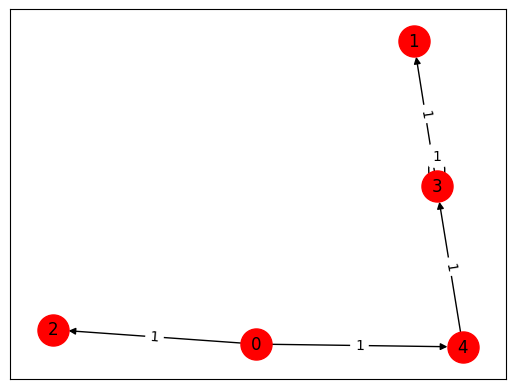

Vertex: 5, levels: [3 2 2 1 1 0]
Vertex: 3, levels: [2 2 1 0 2 1]
Vertex: 4, levels: [2 1 1 2 0 1]


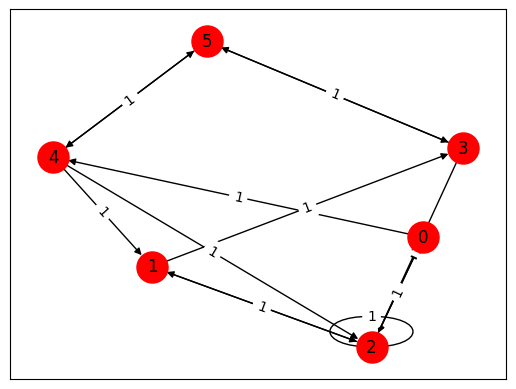

Vertex: 4, levels: [ 3 -1  2  2  0  1  2]
Vertex: 3, levels: [ 1 -1  1  0  2  1  1]
Vertex: 2, levels: [ 4 -1  0  3  1  2  3]
Vertex: 6, levels: [ 2 -1  1  1  2  2  0]
Vertex: 1, levels: [4 0 3 3 1 2 3]
Vertex: 5, levels: [ 2 -1  1  1  1  0  1]


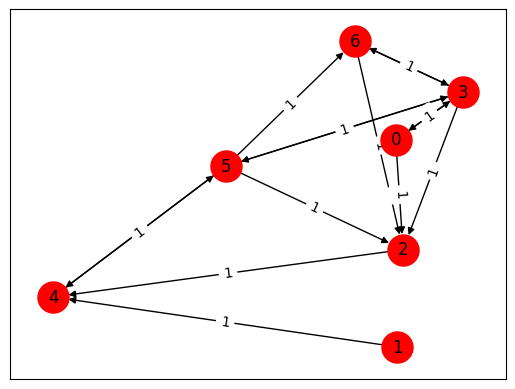

Vertex: 1, levels: [2 0 2 4 3 3 1 3]
Vertex: 5, levels: [1 2 2 3 2 0 3 2]
Vertex: 2, levels: [2 2 0 2 1 1 2 3]
Vertex: 3, levels: [1 2 2 0 1 2 1 2]
Vertex: 7, levels: [1 2 1 3 2 2 1 0]


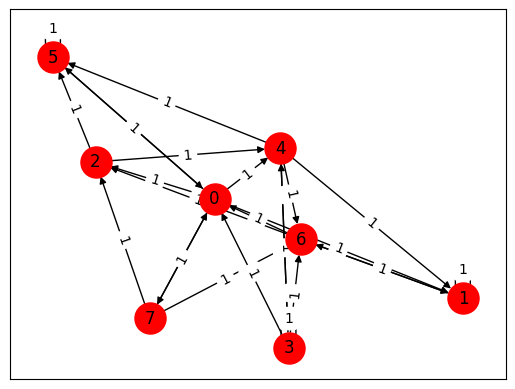

In [10]:
for graph, graph_params in zip(test_graphs, test_graphs_params):
    possible_vertexs = list(range(1, graph_params[0]))
    n_start_vertexs = np.random.randint(1, graph_params[0])
    start_vertexs = np.random.choice(possible_vertexs, n_start_vertexs, replace = False)
    res_list = MSBFS_Levels_any_pair(graph, start_vertexs)
    for vertx, levels in res_list:
        print(f"Vertex: {vertx}, levels: {levels}")
    gb.viz.draw(graph)

In [11]:
def MSBFS_Parents_any_first(A, start_vertexs):
    n_vertexs, n_start_vertexs = A.nrows, len(start_vertexs)
    index_ramp = Matrix(dtypes.UINT64, n_start_vertexs, n_vertexs)
    parents = Matrix(dtypes.UINT64, n_start_vertexs, n_vertexs)
    curr_levels = Matrix(dtypes.UINT64, n_start_vertexs, n_vertexs)
    for idx, vertex in enumerate(start_vertexs):
        for vert_idx in range(n_vertexs):
            index_ramp[idx,vertex] << vertex
    for idx, vertex in enumerate(start_vertexs):
        parents[idx,vertex] << vertex
        curr_levels[idx, vertex] << 1
    while curr_levels.nvals > 0:
        curr_levels << index_ramp.ewise_mult(curr_levels, binary.first)
        curr_levels(~parents.S, replace=True) << curr_levels.mxm(A, semiring.any_first)
        parents(binary.plus) << curr_levels
    res_list = []
    for idx in range(n_start_vertexs):
        buff=[]
        for vert_idx in range(n_vertexs):
            if parents[idx,vert_idx].value is None:
                buff.append(-2)
            elif vert_idx==start_vertexs[idx]:
                buff.append(-1)
            else:
                buff.append(parents[idx,vert_idx].value)
        res_list.append(np.array(buff))
    return list(zip(start_vertexs, res_list))


Vertex: 2, levels: [-2 -2 -1 -2 -2]
Vertex: 1, levels: [-2 -1 -2 -2 -2]
Vertex: 3, levels: [-2  3 -2 -1 -2]
Vertex: 4, levels: [-2 -2 -2  4 -1]


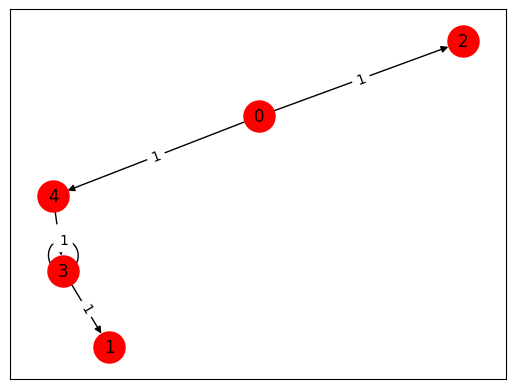

Vertex: 5, levels: [-2 -2 -2  5  5 -1]
Vertex: 2, levels: [ 2  2 -1 -2 -2 -2]


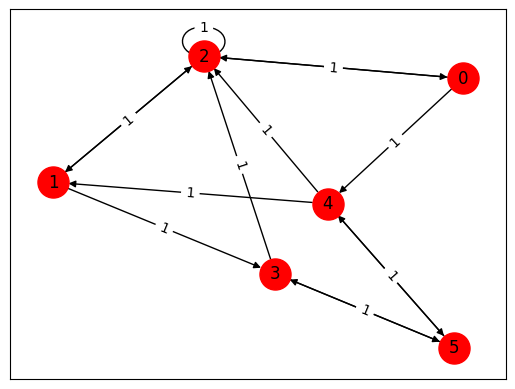

Vertex: 2, levels: [-2 -2 -1 -2  2 -2 -2]
Vertex: 4, levels: [-2 -2 -2 -2 -1  4 -2]
Vertex: 3, levels: [ 3 -2  3 -1 -2  3  3]
Vertex: 1, levels: [-2 -1 -2 -2  1 -2 -2]
Vertex: 6, levels: [-2 -2  6  6 -2 -2 -1]


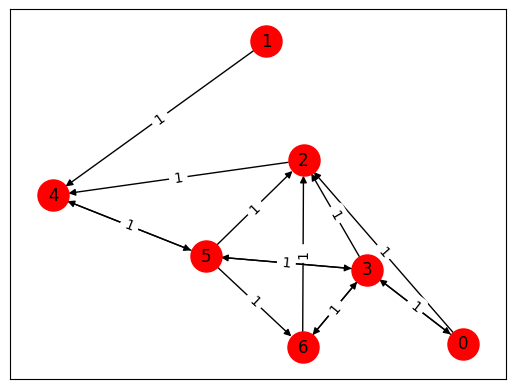

Vertex: 4, levels: [-2  4 -2  4 -1  4  4 -2]
Vertex: 5, levels: [ 5 -2 -2 -2 -2 -1 -2 -2]


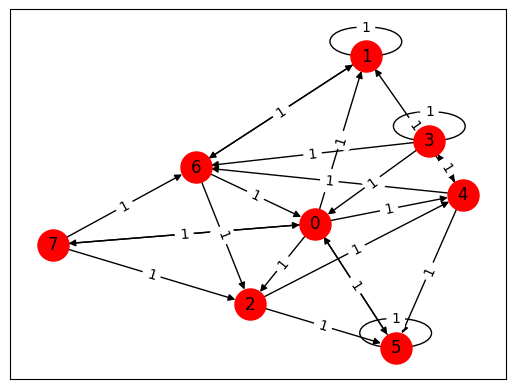

In [12]:
for graph, graph_params in zip(test_graphs, test_graphs_params):
    possible_vertexs = list(range(1, graph_params[0]))
    n_start_vertexs = np.random.randint(1, graph_params[0])
    start_vertexs = np.random.choice(possible_vertexs, n_start_vertexs, replace = False)
    res_list = MSBFS_Parents_any_first(graph, start_vertexs)
    for vertx, levels in res_list:
        print(f"Vertex: {vertx}, levels: {levels}")
    gb.viz.draw(graph)

## 3.Провести экспериментальное исследование полученных реализаций на некоторых больших графах в формате Matrix Market с сайта SuiteSparse Matrix Collection и на случайных сгенерированных. При этом описать зависимость времени работы всех полученных реализаций от размеров графа, его степени разреженности, количестве стартовых вершин.

In [13]:
arr = ssgetpy.search(nzbounds=(400, 1000), isspd=True, limit=10)
arr

23,HB,bcsstk01,48,48,400,real,Yes,Yes,1.0,1.0,structural problem,
25,HB,bcsstk03,112,112,640,real,Yes,Yes,1.0,1.0,structural problem,
44,HB,bcsstk22,138,138,696,real,Yes,Yes,1.0,1.0,structural problem,
61,HB,bcsstm06,420,420,420,real,Yes,Yes,1.0,1.0,structural problem,
69,HB,bcsstm19,817,817,817,real,Yes,Yes,1.0,1.0,structural problem,
70,HB,bcsstm20,485,485,485,real,Yes,Yes,1.0,1.0,structural problem,
220,HB,nos4,100,100,594,real,Yes,Yes,1.0,1.0,structural problem,


In [14]:
arr.download(extract = True, destpath = "./mtx_files")

Overall progress:   0%|          | 0/7 [00:00<?, ?it/s]

bcsstk01:   0%|          | 0/1812 [00:00<?, ?B/s]

bcsstk03:   0%|          | 0/2881 [00:00<?, ?B/s]

bcsstk22:   0%|          | 0/3371 [00:00<?, ?B/s]

bcsstm06:   0%|          | 0/3270 [00:00<?, ?B/s]

bcsstm19:   0%|          | 0/6539 [00:00<?, ?B/s]

bcsstm20:   0%|          | 0/4217 [00:00<?, ?B/s]

nos4:   0%|          | 0/1760 [00:00<?, ?B/s]

In [15]:
mtx_files = glob.glob("mtx_files/*/*.mtx")
big_graphs_list = [mmread(path).dup(dtype=dtypes.BOOL).dup(dtype=dtypes.UINT8) for path in mtx_files]
shutil.rmtree("mtx_files")

In [16]:
def check_time(A_list):
    A_list = sorted(A_list, key=lambda x: x.nvals)
    density = [A.nvals/(A.nrows*A.ncols) for A in A_list]
    parents = []
    levels = []
    parents_any_first = []
    levels_any_pair = []
    n_start_vertexs_list = []
    for A in tqdm(A_list):
        n_start_vertexs = np.random.randint(1, A.nrows//2)
        n_start_vertexs_list.append(n_start_vertexs)
        possible_vertexs = list(range(1, A.nrows))
        start_vertexs = np.random.choice(possible_vertexs, n_start_vertexs, replace = False)
        parents.append(timeit.timeit(lambda: MSBFS_Parents(A, start_vertexs), number=3))
        levels.append(timeit.timeit(lambda: MSBFS_Levels(A, start_vertexs), number=3))
        parents_any_first.append(timeit.timeit(lambda: MSBFS_Parents_any_first(A, start_vertexs), number=3))
        levels_any_pair.append(timeit.timeit(lambda: MSBFS_Levels_any_pair(A, start_vertexs), number=3))

    parents_by_n_start_vertexs = [x for _, x in sorted(zip(n_start_vertexs_list, parents), key=lambda pair: pair[0])]
    levels_by_n_start_vertexs = [x for _, x in sorted(zip(n_start_vertexs_list, levels), key=lambda pair: pair[0])]
    parents_any_first_by_n_start_vertexs = [x for _, x in sorted(zip(n_start_vertexs_list, parents_any_first), key=lambda pair: pair[0])]
    levels_any_pair_by_n_start_vertexs = [x for _, x in sorted(zip(n_start_vertexs_list, levels_any_pair), key=lambda pair: pair[0])]

    parents_by_density = [x for _, x in sorted(zip(density, parents), key=lambda pair: pair[0])]
    levels_by_density = [x for _, x in sorted(zip(density, levels), key=lambda pair: pair[0])]
    parents_any_first_by_density = [x for _, x in sorted(zip(density, parents_any_first), key=lambda pair: pair[0])]
    levels_any_pair_by_density = [x for _, x in sorted(zip(density, levels_any_pair), key=lambda pair: pair[0])]

    plt.figure(figsize=(30, 30))
    plt.plot(parents, label="parents")
    plt.plot(levels, label="levels")
    plt.plot(parents_any_first, label="parents_any_first")
    plt.plot(levels_any_pair, label="levels_any_pair")
    plt.xlabel('nonzero vals | num start vertexs | density')
    plt.ylabel('time')
    labels = [str(A.nvals) + " | " + str(n_start_vertexs) + " | " + str(round(density_, 3)) for A, n_start_vertexs, density_ in zip(A_list, n_start_vertexs_list, density)]
    plt.xticks(np.arange(len(A_list)), labels = labels)
    plt.legend()
    plt.title("sorted by nvals")
    plt.show()

    plt.figure(figsize=(30, 30))
    plt.plot(parents_by_n_start_vertexs, label="parents")
    plt.plot(levels_by_n_start_vertexs, label="levels")
    plt.plot(parents_any_first_by_n_start_vertexs, label="parents_any_first")
    plt.plot(levels_any_pair_by_n_start_vertexs, label="levels_any_pair")
    plt.xlabel('num start vertexs')
    plt.ylabel('time')
    labels = [str(n_start_vertexs) for n_start_vertexs in sorted(n_start_vertexs_list)]
    plt.xticks(np.arange(len(A_list)), labels = labels)
    plt.legend()
    plt.title("sorted by n_start_vertexs")
    plt.show()

    plt.figure(figsize=(30, 30))
    plt.plot(parents_by_density, label="parents")
    plt.plot(levels_by_density, label="levels")
    plt.plot(parents_any_first_by_density, label="parents_any_first")
    plt.plot(levels_any_pair_by_density, label="levels_any_pair")
    plt.xlabel('density')
    plt.ylabel('time')
    labels = [str(round(density_, 3)) for density_ in sorted(density)]
    plt.xticks(np.arange(len(A_list)), labels = labels)
    plt.legend()
    plt.title("sorted by density")
    plt.show()

100%|██████████| 7/7 [02:24<00:00, 20.64s/it]


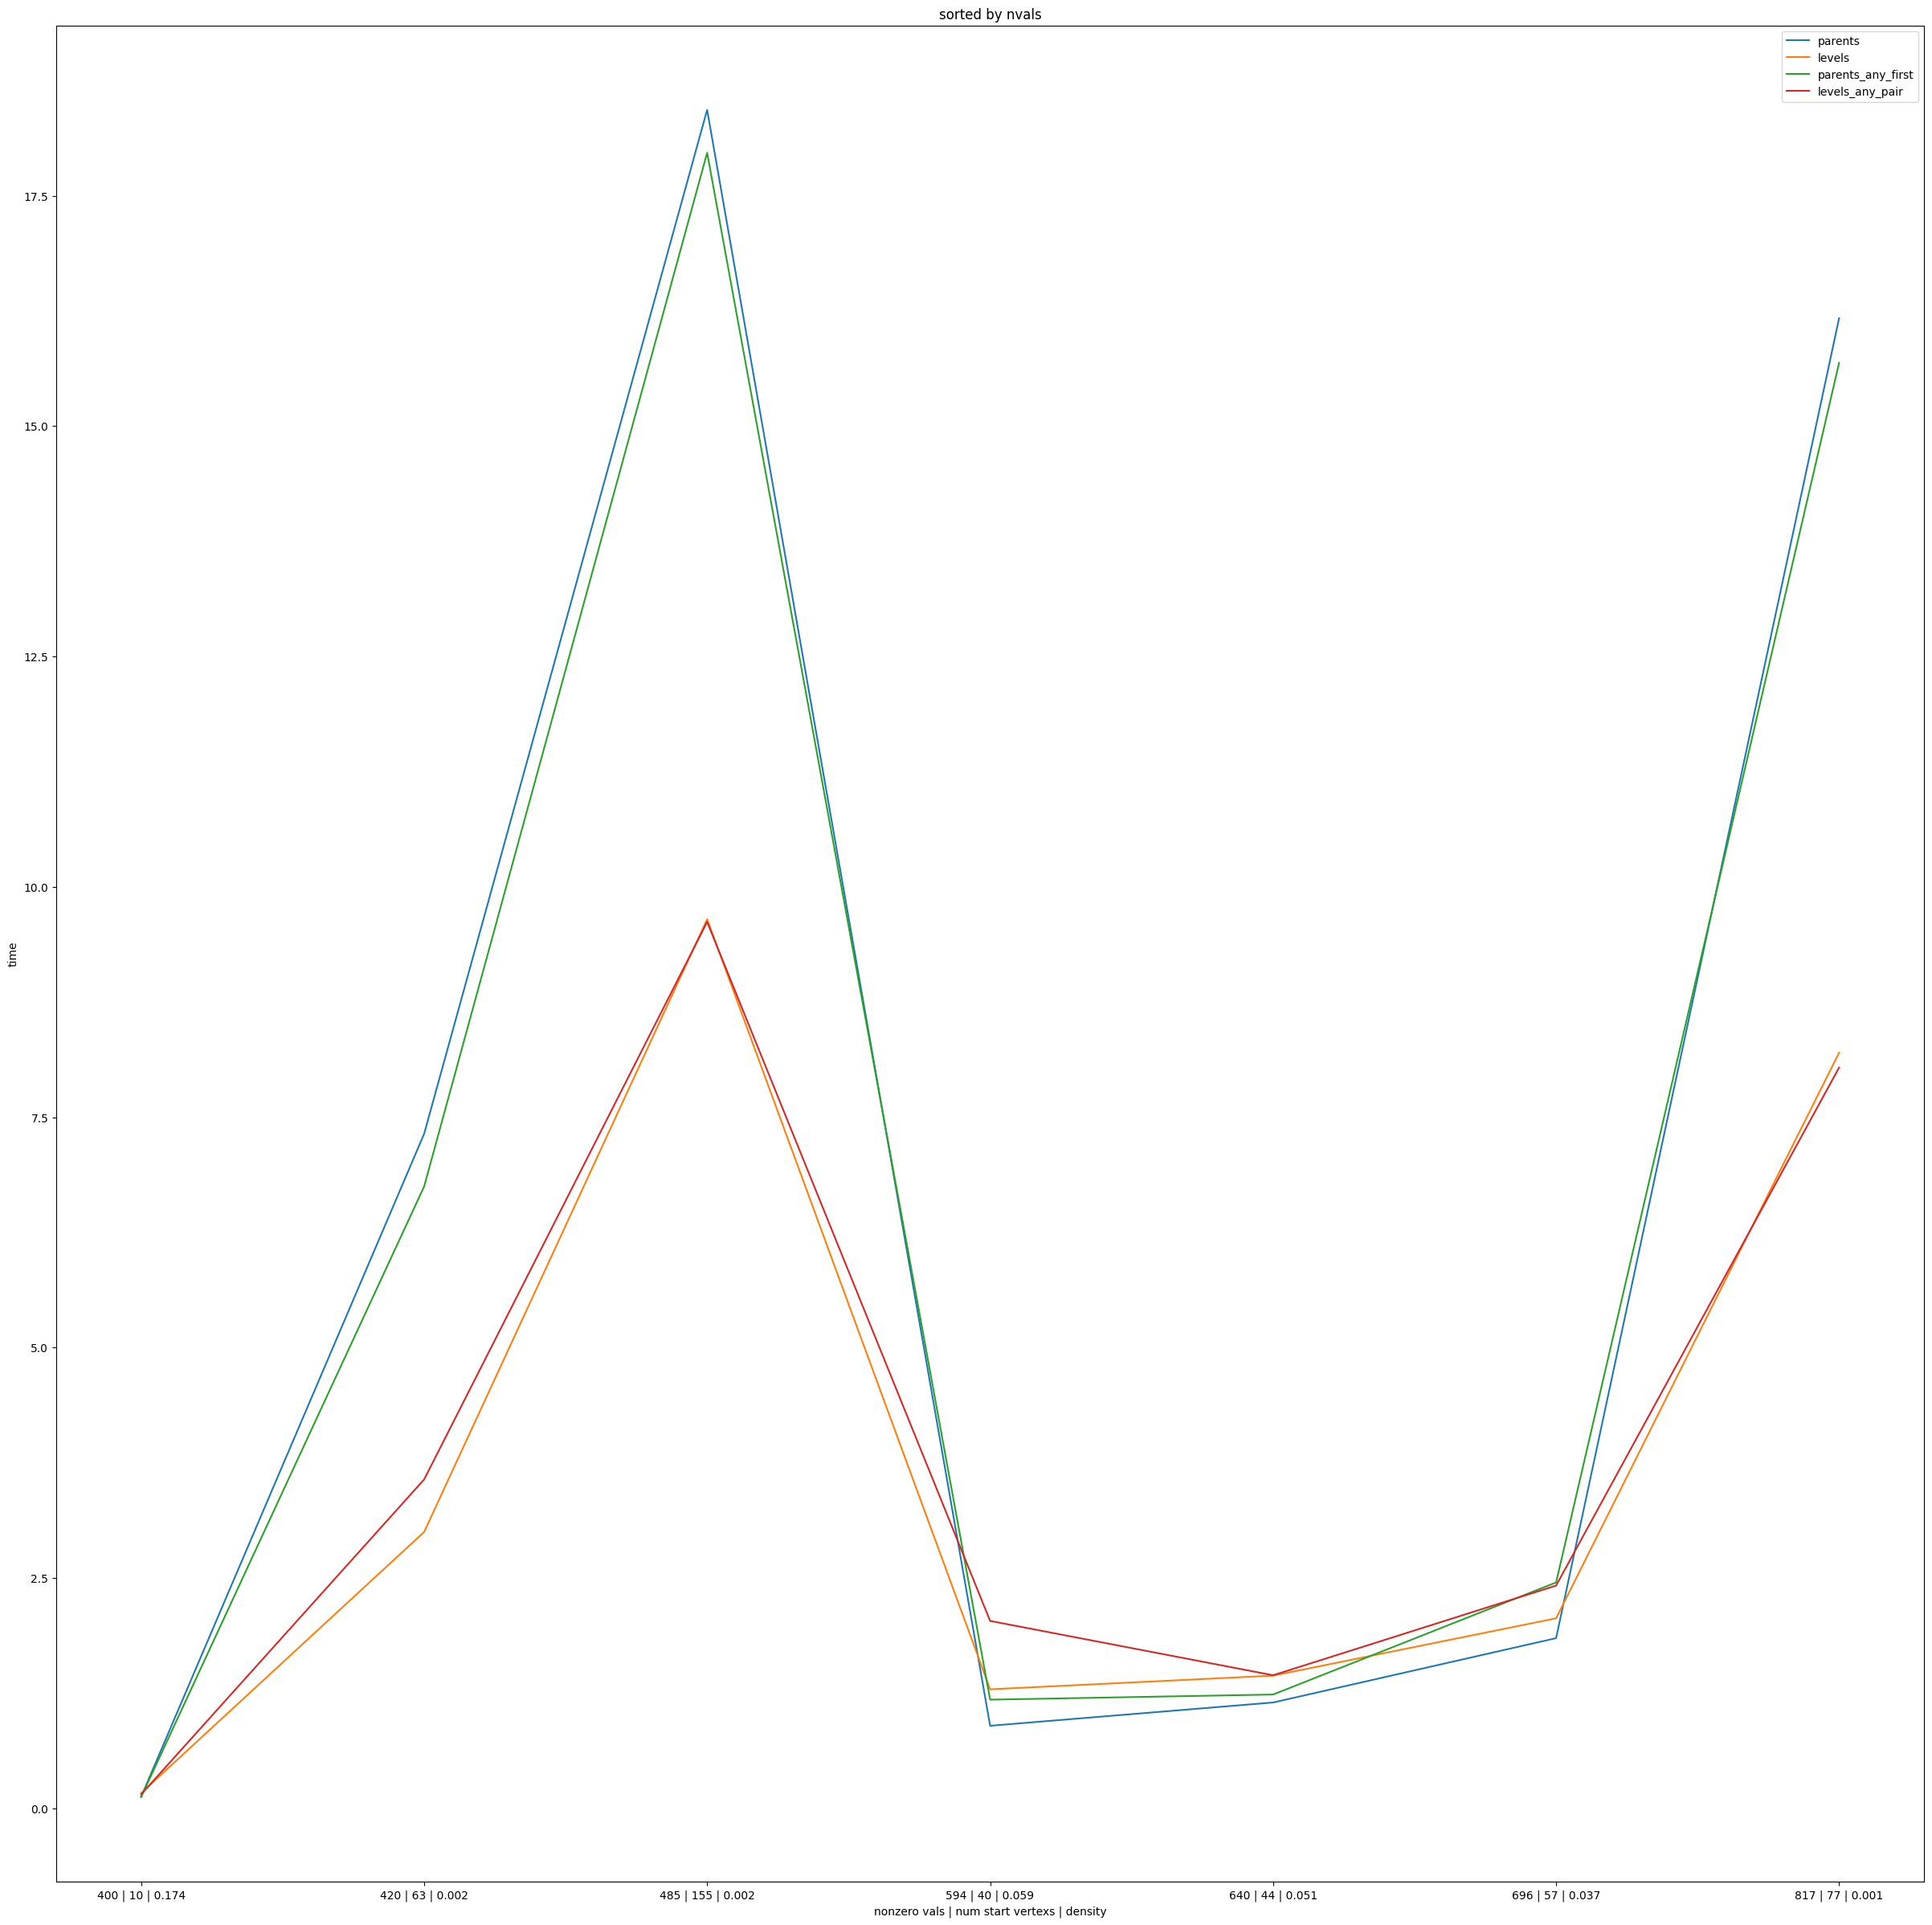

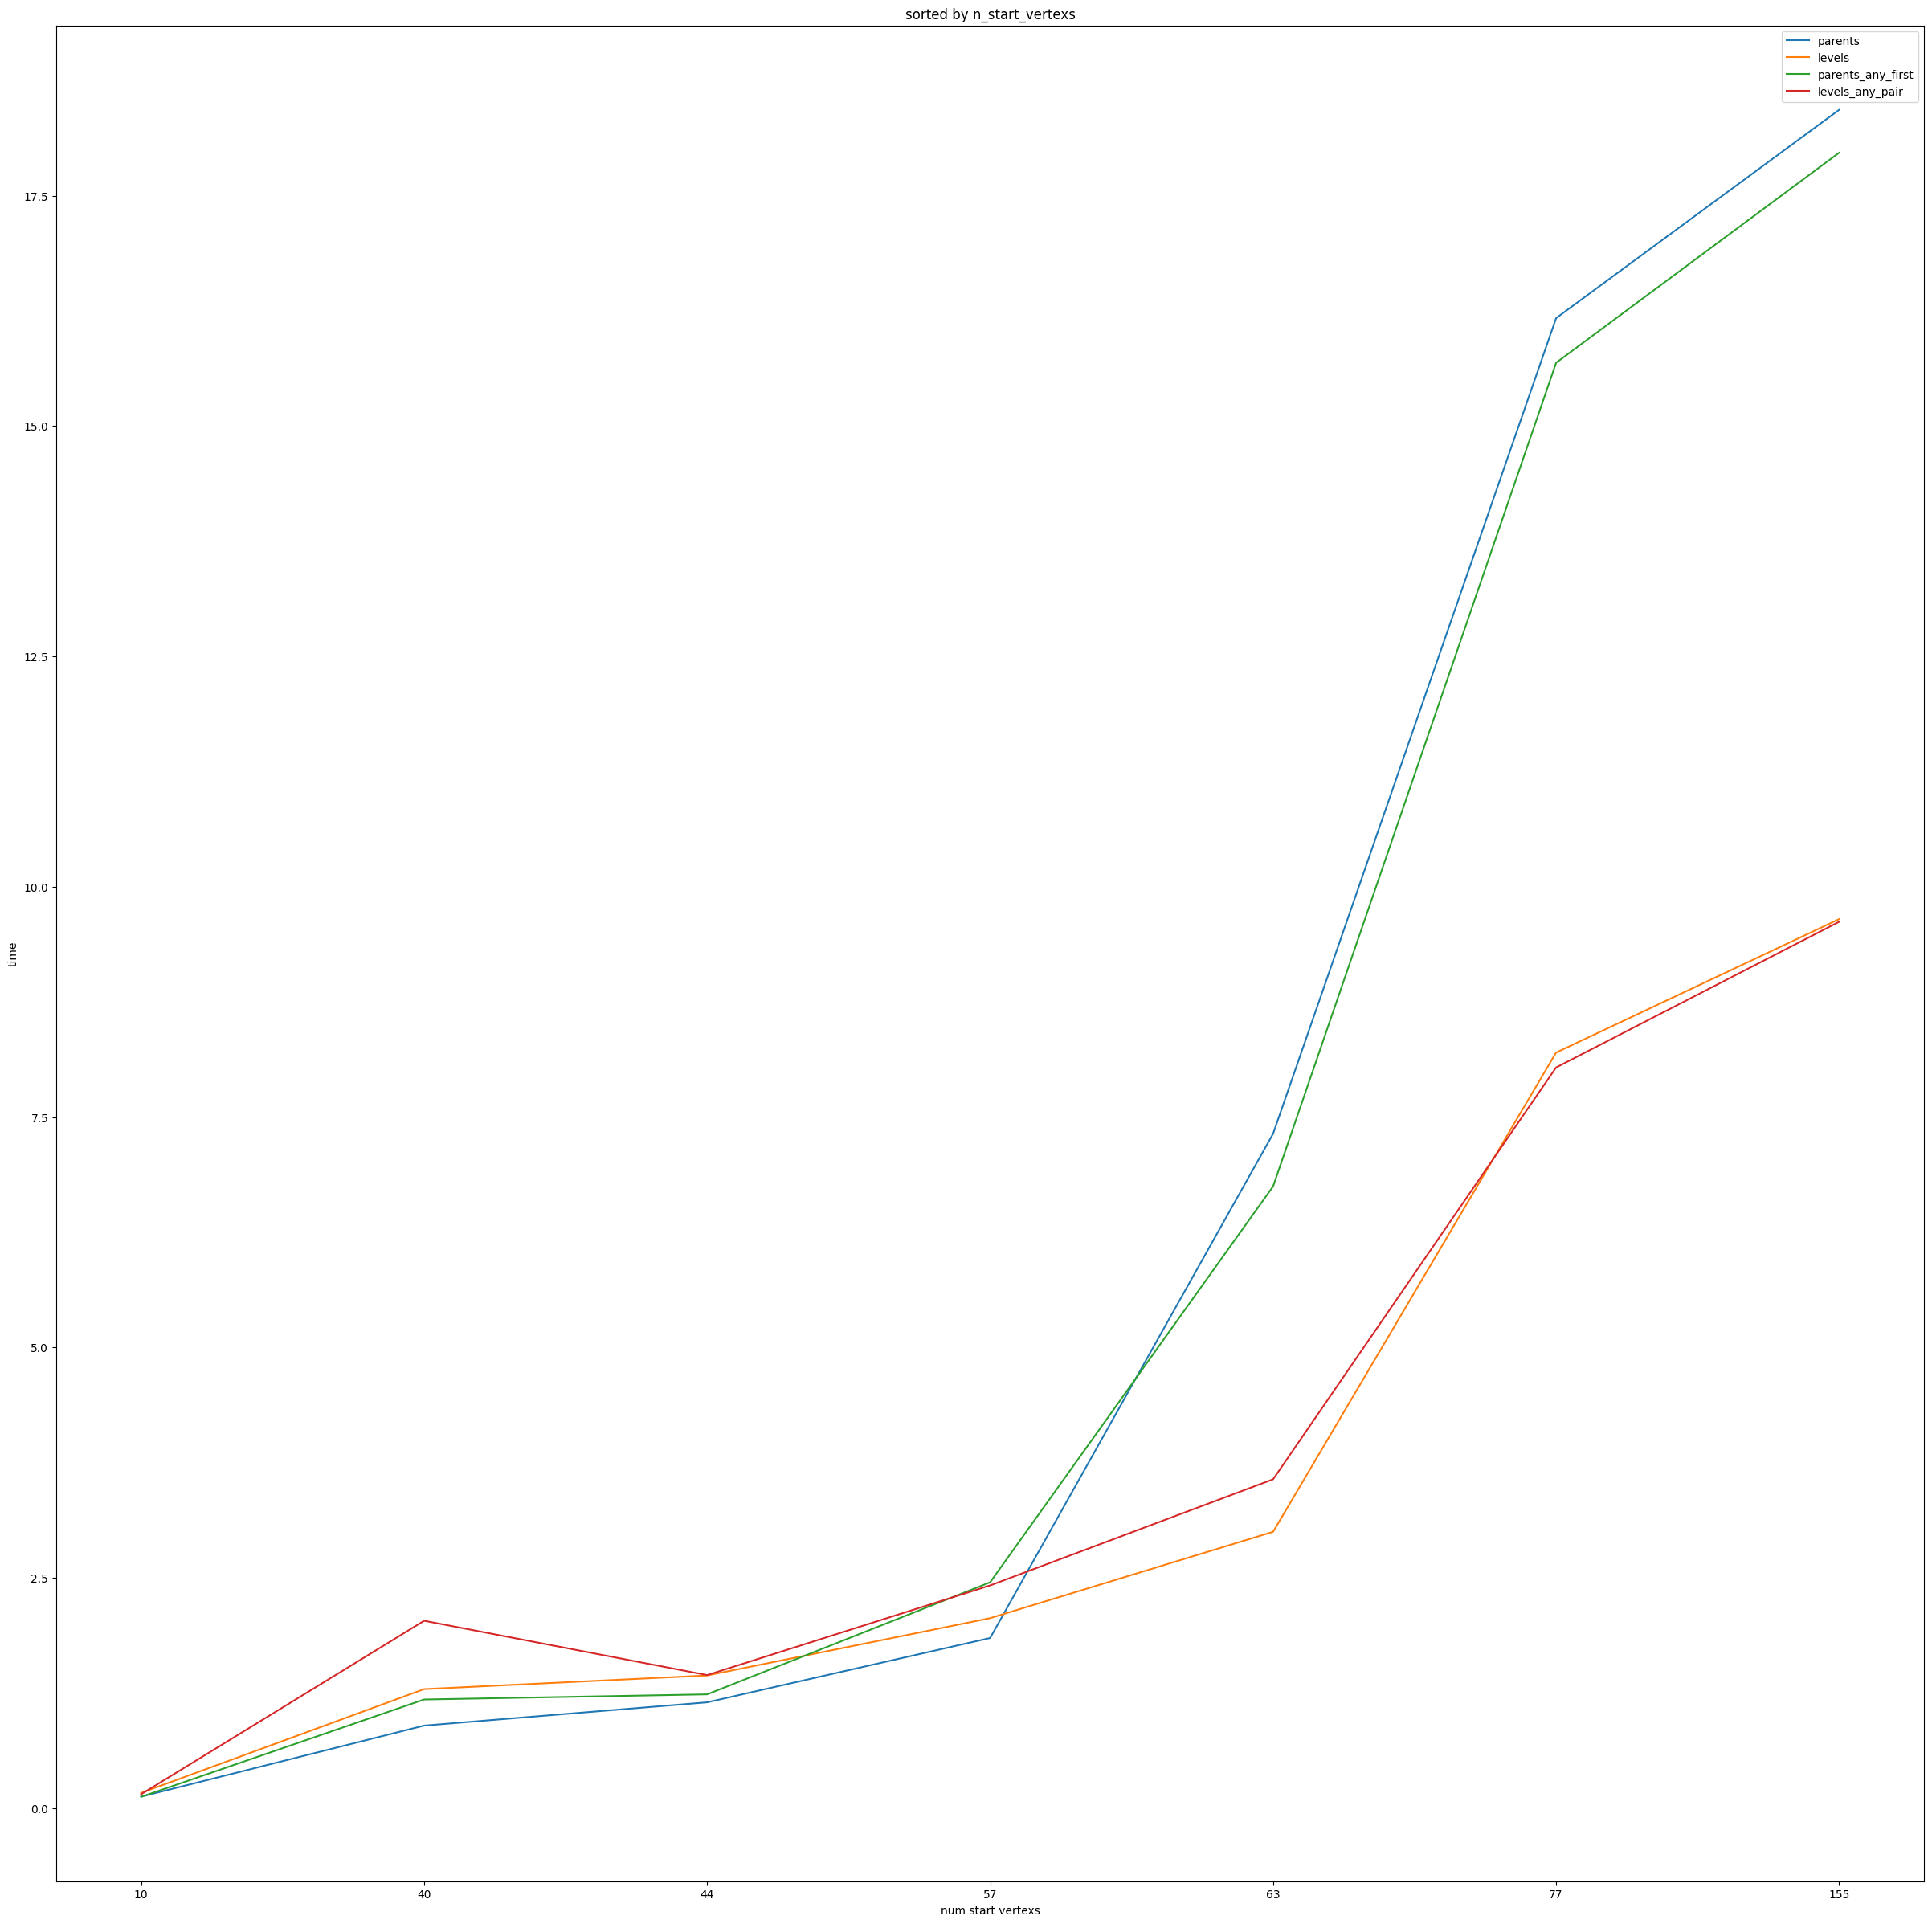

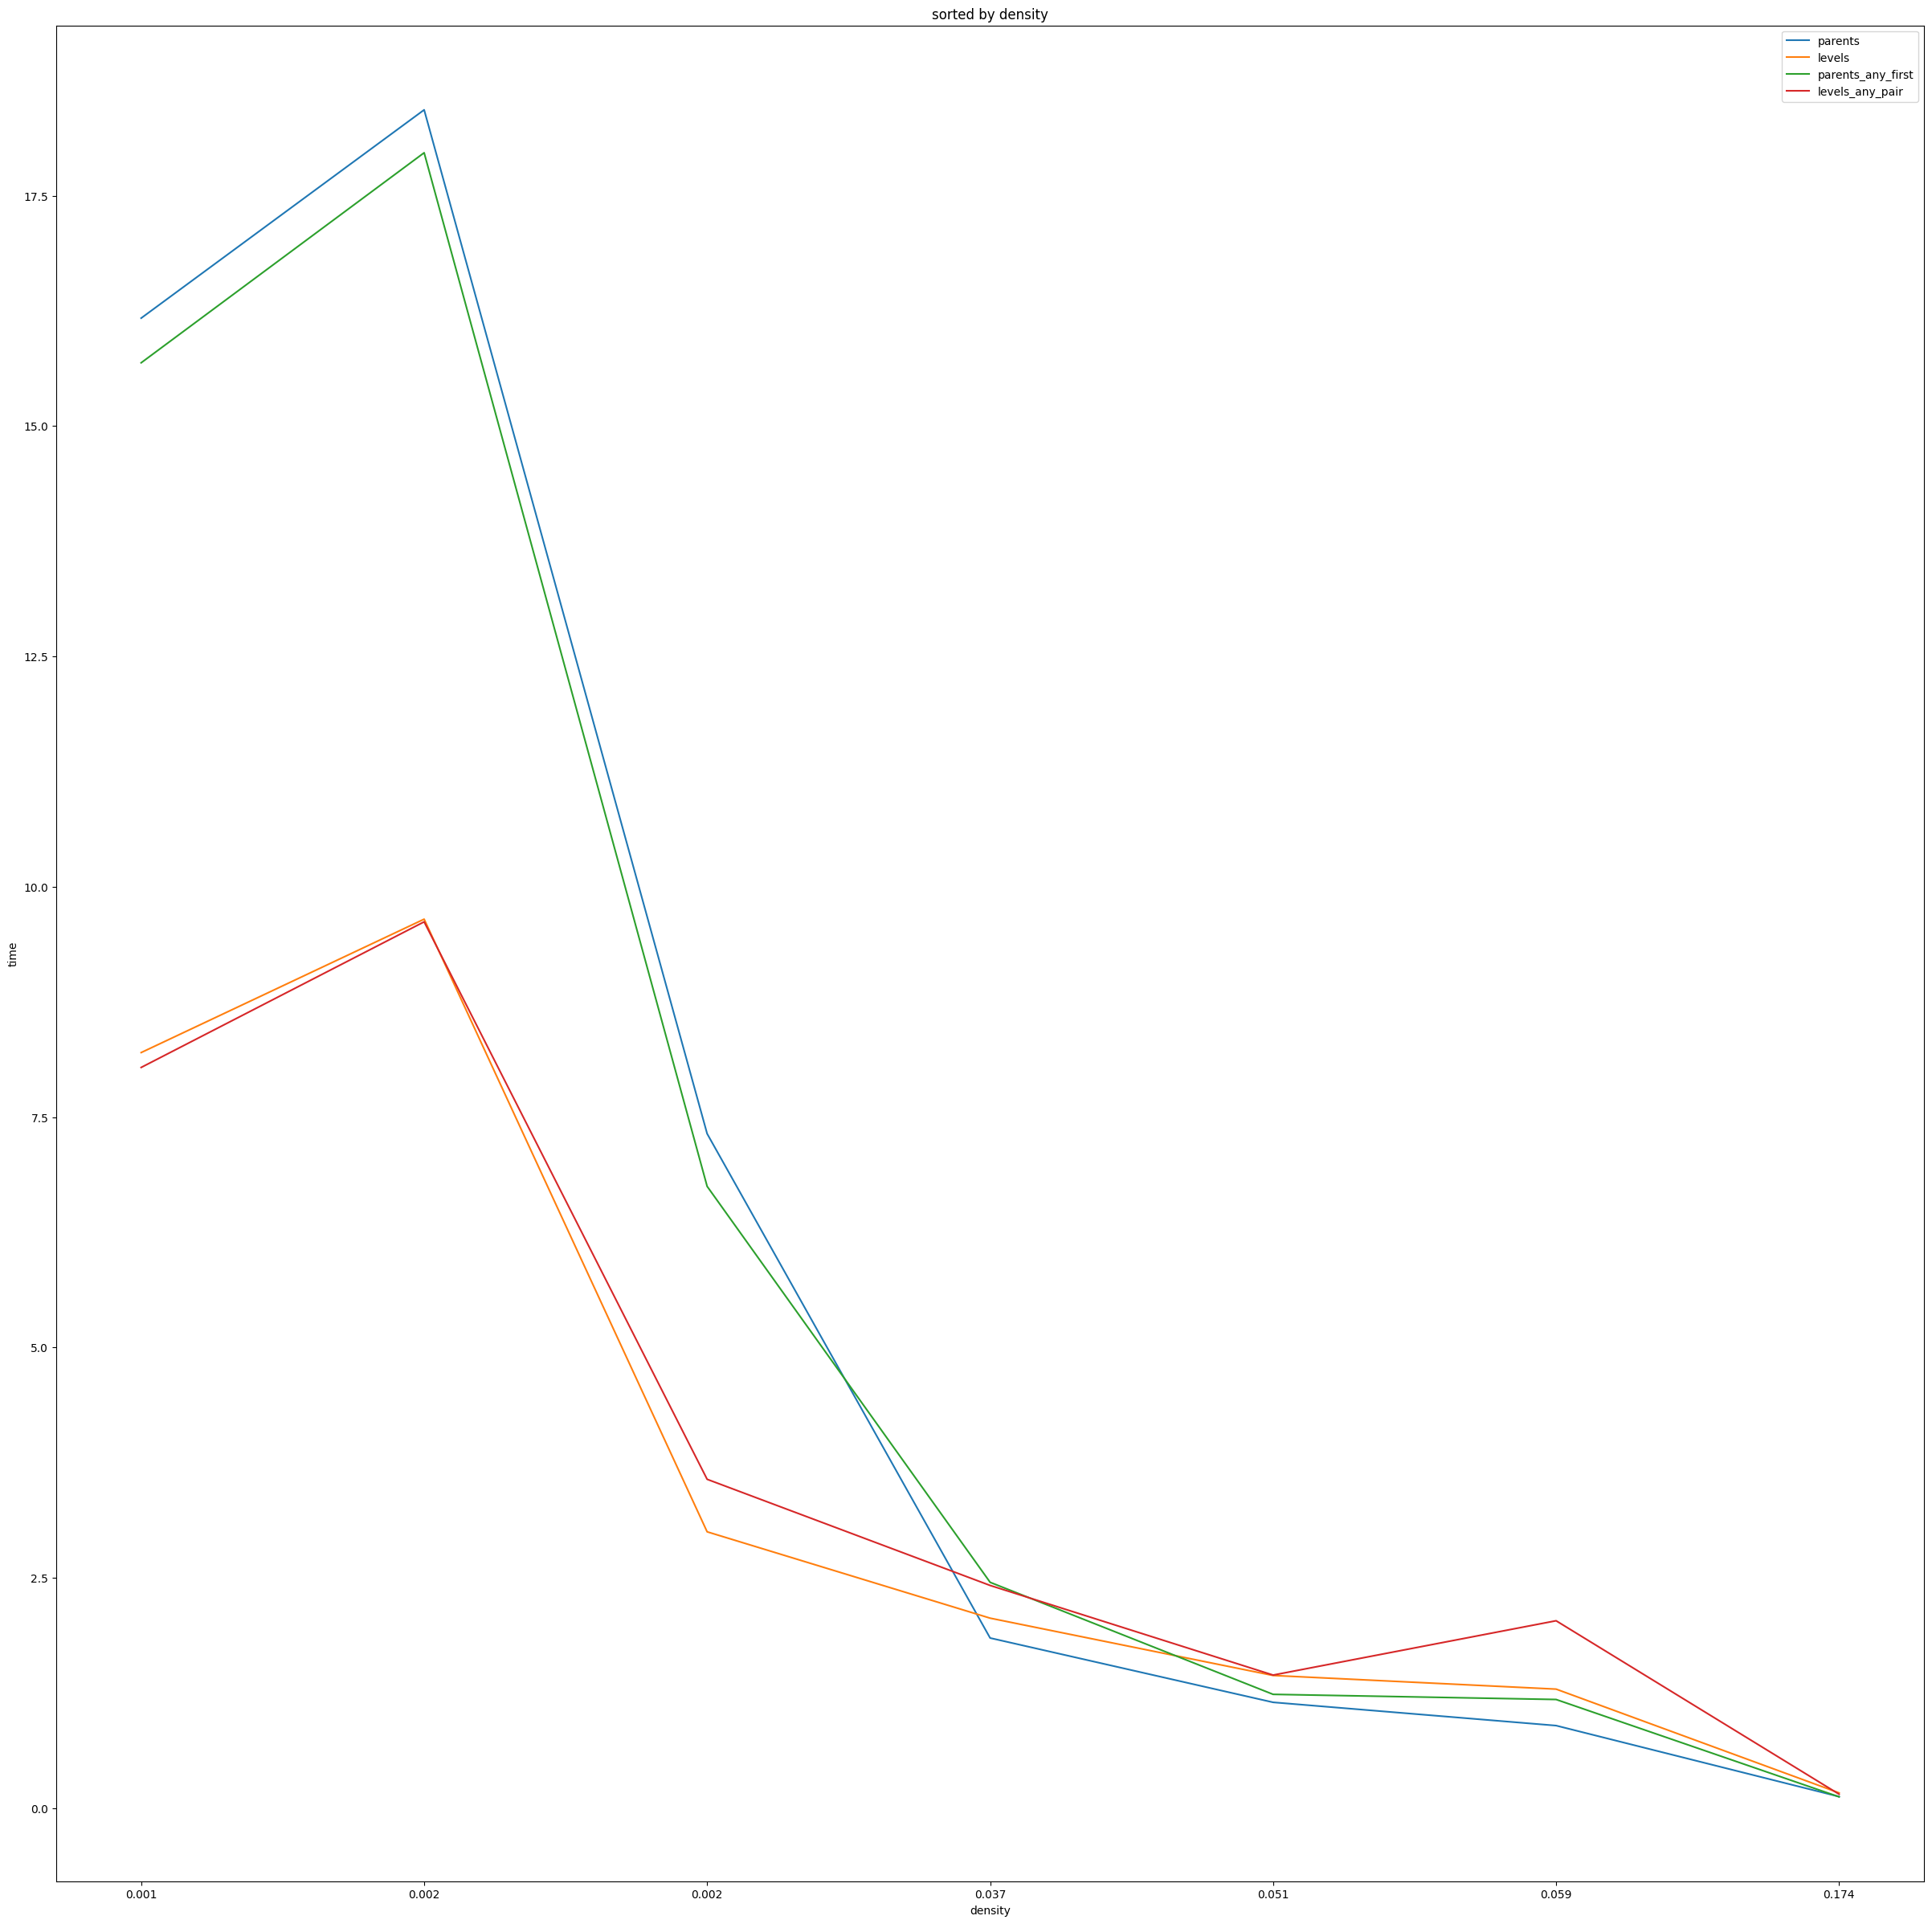

In [17]:
check_time(big_graphs_list)

Выводы:
1. Наблюдаем окололинейную растущую зависимость от числа стартовых вершин
2. Время сильно растет в зависимости от числа вершин и числа ненулевых знвчений (число вершин влияет на время исполнение одной итерациии, число связей влияет на их количество)
3. Время работы алгоритмов с разными кольцами сравнимо между собой: MSBFS_Parents_any_first работает чуть лучше на малых графах, но немного уступает на больших MSBFS_Parents, аналогично MSBFS_Levels работает лучше на больших, а MSBFS_Levels_any_pair на малых